In [ ]:
#pip install tensorflow

In [15]:
import re
import os
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
import tensorflow.keras.layers

from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, MaxPooling1D, Conv1D, Flatten, Dense

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential

from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam

In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fayza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fayza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fayza\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\fayza\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Phase One

In [18]:
dataset = pd.read_csv("file.csv")

In [19]:
#tokenization
def tokenize(tweet):
    return word_tokenize(tweet)

#lowering 
def lowercase_tweet(tweet):
    return tweet.lower()

#removing stop words
stop_words = set(stopwords.words('english'))
def remove_stop_words(tokens):
    return [token for token in tokens if token not in stop_words]

#lemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_tweet(words):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    # join the lemmatized words back into a sentence
    lemmatized_tweet = " ".join(lemmatized_words)
    return lemmatized_tweet

#removing emails, special characters and URLs
def handle_special_characters(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'www.\S+', '', tweet)
    # Remove email addresses
    tweet = re.sub(r'\S+@\S+', '', tweet)
    # Remove numbers
    tweet = re.sub(r'[0-9]', '', tweet)
    # Remove special characters, punctuation and emoji
    tweet = re.sub(r'[^\w\s]', '', tweet)
    return tweet

def pre_processing(tweet):
    tweet = lowercase_tweet(tweet)
    tweet = handle_special_characters(tweet)
    tokens = tokenize(tweet)
    words = remove_stop_words(tokens)
    lemmatized_tweet = lemmatize_tweet(words)
    #stemmed_tweet = stem_tweet(words)
    return lemmatized_tweet

#pre_processing the tweets column
dataset['tweets']  = dataset['tweets'].apply(lambda x:pre_processing(x))

In [21]:
# Create separate folders for training and testing data
if not os.path.exists('../training_data'):
    os.mkdir('../training_data')
if not os.path.exists('../testing_data'):
    os.mkdir('../testing_data')


if not os.path.exists(os.path.join('../training_data', 'train_data.csv')) and not os.path.exists(os.path.join('../testing_data', 'test_data.csv')):
    # Split the dataset into training 80% and testing data 20% (horizontally)
    train_data = dataset.sample(frac=0.8, random_state=42)
    test_data = dataset.drop(train_data.index)

    # Save the training and testing data as csv files
    train_data.to_csv('../train_data.csv', index=False)
    test_data.to_csv('../test_data.csv', index=False)

    # Move the respective csv files into the training and testing folders
    os.rename('../train_data.csv', os.path.join('../training_data', 'train_data.csv'))
    os.rename('../test_data.csv', os.path.join('../testing_data', 'test_data.csv'))

In [11]:
training = pd.read_csv("../training_data/train_data.csv") #80%
testing = pd.read_csv("../testing_data/test_data.csv")    #20%

In [12]:
max_length = 70

def word_embedding(training, testing):
    train_tweet_list = training['tweets'].tolist()
    train_tweet_list = [str(tweet) for tweet in training['tweets']]

    test_tweet_list = testing['tweets'].tolist()
    test_tweet_list = [str(tweet) for tweet in testing['tweets']]
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(train_tweet_list)
    
    train_sequences = tokenizer.texts_to_sequences(train_tweet_list)
    test_sequences = tokenizer.texts_to_sequences(test_tweet_list)
    
    word_index = tokenizer.word_index
   
    train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length)
    test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length)

    return train_padded_sequences, test_padded_sequences, word_index, tokenizer

In [13]:
def encode_labels(data):
    labels = ['bad', 'neutral' ,'good']
    label_to_int = {label: i for i, label in enumerate(labels)}
    labels_column = data['labels']

    three_labels = len(labels) #3
    labels_column_len = len(labels_column) #175435

    one_hot_matrix = np.zeros((labels_column_len, three_labels)) #initialization with 0
    for i, label in enumerate(labels_column):
        index = label_to_int[label]
        one_hot_matrix[i, index] = 1
    return one_hot_matrix 

In [14]:
trainX, testX, word_index, tokenizer = word_embedding(training, testing)
trainY = encode_labels(training)
testY = encode_labels(testing)

In [14]:
embedding_dim = 300
embedding_dict = {}
vocab_size = len(word_index) + 1

with open('./glove.6B.300d.txt', 'r', encoding='utf-8') as glove:
    for line in glove:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_dict[word] = vector

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=True)

# Phase Two
# CNN

In [15]:
def CNN_model(num_filters, kernel_size, learning_rate):
    model = Sequential()
    model.add(embedding_layer)
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [17]:
# 1D CNN Layers
cnn_model = CNN_model(num_filters=500, kernel_size=3, learning_rate=0.001)
cnn_model.fit(trainX, trainY, epochs=5, batch_size=128)

Epoch 1/5
1371/1371 [==============================] - 900s 655ms/step - loss: 0.6726 - accuracy: 0.7271
Epoch 2/5
1371/1371 [==============================] - 925s 675ms/step - loss: 0.5509 - accuracy: 0.7908
Epoch 3/5
1371/1371 [==============================] - 825s 601ms/step - loss: 0.4823 - accuracy: 0.8205
Epoch 4/5
1371/1371 [==============================] - 821s 599ms/step - loss: 0.4126 - accuracy: 0.8476
Epoch 5/5
1371/1371 [==============================] - 823s 600ms/step - loss: 0.3420 - accuracy: 0.8747


In [18]:
loss, acc = cnn_model.evaluate(testX, testY)
print('Test accuracy:', (acc*100))

1371/1371 [==============================] - 50s 36ms/step - loss: 0.6865 - accuracy: 0.7653
Test accuracy: 76.5293300151825


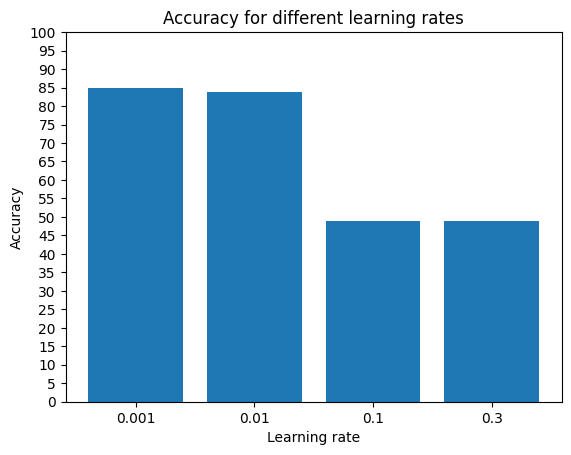

In [ ]:
# testing the model with different learning rate! 
num_filters = 300
kernel_size = 3
learning_rates = [0.001, 0.01, 0.1, 0.3]

lr_accuracies = []

# Train and evaluate the model for each learning rate
for lr in learning_rates:
    model = CNN_model(num_filters, kernel_size, lr)
    history = model.fit(trainX, trainY, epochs=5, batch_size=128, verbose=0)
    loss, accuracy = model.evaluate(testX, testY, verbose=0)
    lr_accuracies.append(accuracy*100)

# Plot the accuracy for different learning rates
x_ticks = np.arange(len(learning_rates))
plt.bar(x_ticks, lr_accuracies)
plt.xticks(x_ticks, learning_rates)
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.ylim([0, 100]) 
plt.yticks(np.arange(0, 105, 5))
plt.title('Accuracy for different learning rates')
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


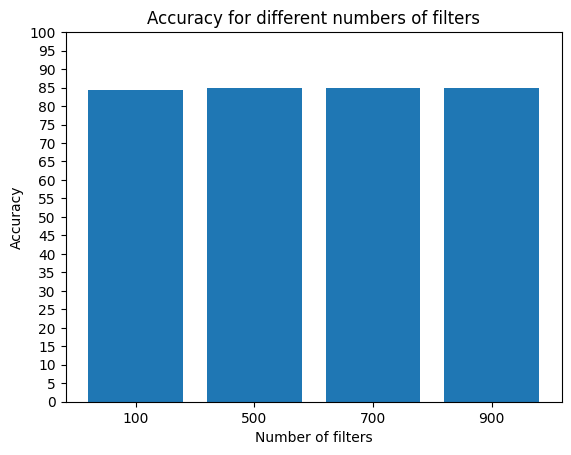

In [ ]:
# testing the model with different numbers of filters! 
num_filters_list = [100, 500, 700, 900]
kernel_size = 3
learning_rate = 0.001

filters_accuracies = []

# Train and evaluate the model for each number of filters
for num_filters in num_filters_list:
    model = CNN_model(num_filters, kernel_size, learning_rate)
    history = model.fit(trainX, trainY, epochs=5, batch_size=128, verbose=0)
    loss, accuracy = model.evaluate(testX, testY, verbose=0)
    filters_accuracies.append(accuracy*100)

# Plot the accuracy for different numbers of filters
x_ticks = np.arange(len(num_filters_list))
plt.bar(x_ticks, filters_accuracies)
plt.xticks(x_ticks, num_filters_list)
plt.xlabel('Number of filters')
plt.ylabel('Accuracy')
plt.ylim([0, 100]) 
plt.yticks(np.arange(0, 105, 5))
plt.title('Accuracy for different number of filters')
plt.show()

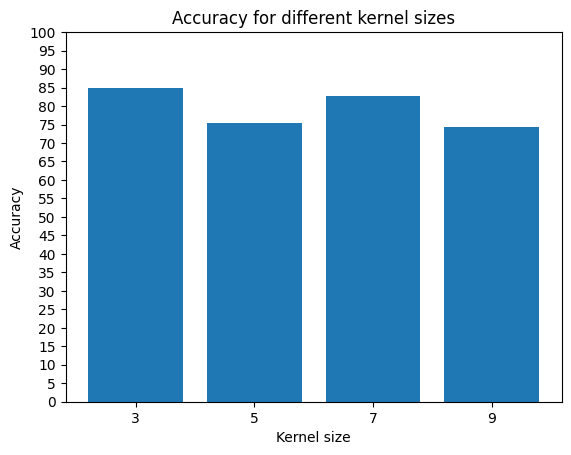

In [ ]:
# testing the model with different kernel sizes! 
num_filters = 500
kernel_size_list = [3, 5, 7, 9]
learning_rate = 0.001

# Create lists to store the results
kernel_accuracies = []

# Train and evaluate the model for each kernel size
for kernel_size in kernel_size_list:
    model = CNN_model(num_filters, kernel_size, learning_rate)
    history = model.fit(trainX, trainY, epochs=5, batch_size=128, verbose=0)
    loss, accuracy = model.evaluate(testX, testY, verbose=0)
    kernel_accuracies.append(accuracy*100)

# Plot the accuracy for different kernel sizes
x_ticks = np.arange(len(kernel_size_list))
plt.bar(x_ticks, kernel_accuracies)
plt.xticks(x_ticks, kernel_size_list)
plt.xlabel('Kernel size')
plt.ylabel('Accuracy')
plt.title('Accuracy for different kernel sizes')
plt.ylim([0, 100]) 
plt.yticks(np.arange(0, 105, 5))
plt.show()

# LSTM


In [16]:
def LSTM_model(lr, epochs, batch_size):
  model = Sequential()
  model.add(embedding_layer)
  model.add(layers.LSTM(128))
  model.add(Dense(units=3, activation='sigmoid'))

  opt = keras.optimizers.Adam(learning_rate=lr)

  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, verbose=0)
  return model

In [ ]:
lstm_model = LSTM_model(lr=0.001, epochs=5, batch_size=64)
loss, acc = lstm_model.evaluate(testX, testY, verbose=0)
print('Test accuracy:', (acc*100)) 

Test accuracy: 87.81322240829468


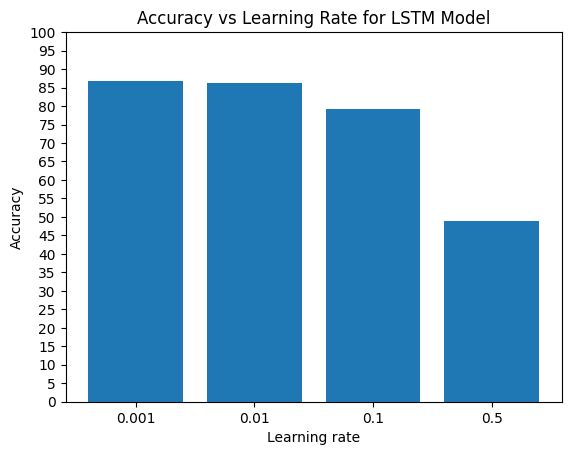

In [ ]:
# testing the model with different learning rate! 
learning_rates = [0.001, 0.01, 0.1, 0.5]
accuracies_lr_LSTM = []

for lr in learning_rates:
    model = LSTM_model(lr, epochs=10, batch_size=128)
    loss, accuracy = model.evaluate(testX, testY, verbose=0)
    accuracies_lr_LSTM.append(accuracy*100)

x_ticks = np.arange(len(learning_rates))
plt.bar(x_ticks, accuracies_lr_LSTM)
plt.xticks(x_ticks, learning_rates)
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate for LSTM Model')
plt.ylim([0, 100]) 
plt.yticks(np.arange(0, 105, 5))
plt.show()

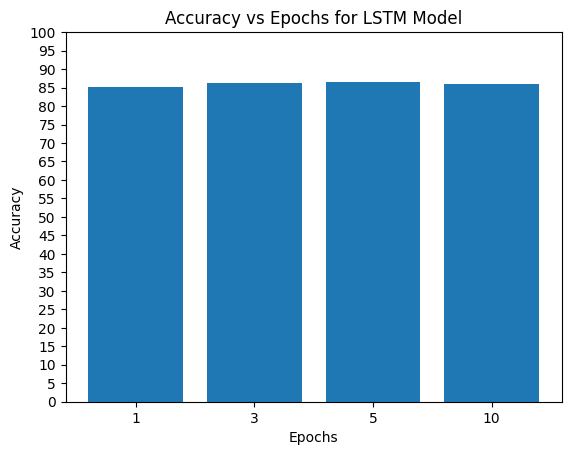

In [ ]:
# testing the model with different epochs! 
epochs = [1, 3, 5, 10]
learning_rates = 0.01
accuracies_epoch_LSTM = []

for epch in epochs:
    model = LSTM_model(learning_rates, epch, batch_size=128)
    loss, accuracy = model.evaluate(testX, testY, verbose=0)
    accuracies_epoch_LSTM.append(accuracy*100)

x_ticks = np.arange(len(epochs))
plt.bar(x_ticks, accuracies_epoch_LSTM)
plt.xticks(x_ticks, epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs for LSTM Model')
plt.ylim([0, 100]) 
plt.yticks(np.arange(0, 105, 5))
plt.show()

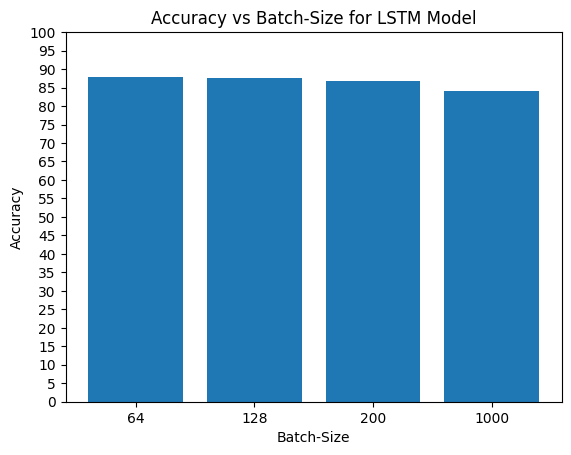

In [ ]:
# testing the model with different batch size! 
epochs = 5
learning_rate = 0.001
batch_sizes = [64, 128, 200, 1000]
accuracies_batch_LSTM = []

for bat in batch_sizes:
    model = LSTM_model(learning_rate, epochs, bat)
    loss, accuracy = model.evaluate(testX, testY, verbose=0)
    accuracies_batch_LSTM.append(accuracy*100)

x_ticks = np.arange(len(batch_sizes))
plt.bar(x_ticks, accuracies_batch_LSTM)
plt.xticks(x_ticks, batch_sizes)
plt.xlabel('Batch-Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Batch-Size for LSTM Model')
plt.ylim([0, 100]) 
plt.yticks(np.arange(0, 105, 5))
plt.show()

# Prediction of Sentiment Analysis of a new tweet

In [17]:
def predict_tweet(new_tweet, model, tokenizer):
    new_tweet = pre_processing(new_tweet)
    new_tweet = tokenizer.texts_to_sequences([new_tweet])
    new_tweet = pad_sequences(new_tweet, maxlen=max_length)

    prediction = model.predict(new_tweet)

    # Convert the prediction to a sentiment label
    sentiment_index = np.argmax(prediction)

    if sentiment_index == 0:
        print('The Sentiment Analysis result of the tweet is negative')
    elif sentiment_index == 1:
        print('The Sentiment Analysis result of the tweet is neutral')
    else:
        print('The Sentiment Analysis result of the tweet is positive')

In [ ]:
# Taking the input
new_tweet = input('Enter a new tweet: ')

Enter a new tweet: openai launched chatgpt


In [ ]:
# CNN Prediction
predict_tweet(new_tweet, cnn_model, tokenizer)

1/1 [==============================] - 0s 27ms/step
The Sentiment Analysis result of the tweet is neutral


In [ ]:
# LSTM Prediction
predict_tweet(new_tweet, lstm_model, tokenizer)

1/1 [==============================] - 0s 28ms/step
The Sentiment Analysis result of the tweet is neutral
